In [1]:
import glob
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load data from all xlsm files in the PENJUALAN folder
folder_path = "./data/Bobby Aquatic 1"  # Ganti dengan path yang sesuai
all_files = glob.glob(os.path.join(folder_path, "*.xlsm"))

In [3]:
dfs = []
for file in all_files:
    df = pd.read_excel(file, sheet_name="Penjualan")
    # Avoid duplicate column names
    if 'KODE BARANG' in df.columns:
        df = df.loc[:, ~df.columns.duplicated()]  # Remove duplicate columns
    dfs.append(df)

# Menggabungkan semua data
data = pd.concat(dfs, ignore_index=True)

In [4]:
# Melihat jumlah baris dalam DataFrame
num_rows = data.shape[0]
print(f"Jumlah baris: {num_rows}")

Jumlah baris: 11820


In [4]:
# Step 2: Calculate RFM
# Convert 'TANGGAL' to datetime format if necessary
data['TANGGAL'] = pd.to_datetime(data['TANGGAL'])

# Calculate Recency, Frequency, and Monetary
reference_date = data['TANGGAL'].max()  # Set the reference date for Recency
rfm = data.groupby('KODE BARANG').agg({
    'TANGGAL': lambda x: (reference_date - x.max()).days,  # Recency
    'NAMA BARANG': 'count',  # Frequency (use NAMA BARANG or any other column instead)
    'TOTAL HR JUAL': 'sum'  # Monetary (Revenue)
}).reset_index()

# Rename columns
rfm.columns = ['KODE BARANG', 'Recency', 'Frequency', 'Monetary']

# Check the result
print(rfm.head())

  KODE BARANG  Recency  Frequency   Monetary
0         AA1      178          5   560000.0
1        AA10      135          8  2880000.0
2         AA2       83          6  3040000.0
3         AA4      107          5   590000.0
4         AA5       35          6   700000.0


In [12]:
# Step 3: Apply Elbow Method to find optimal number of clusters
# Standardizing the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

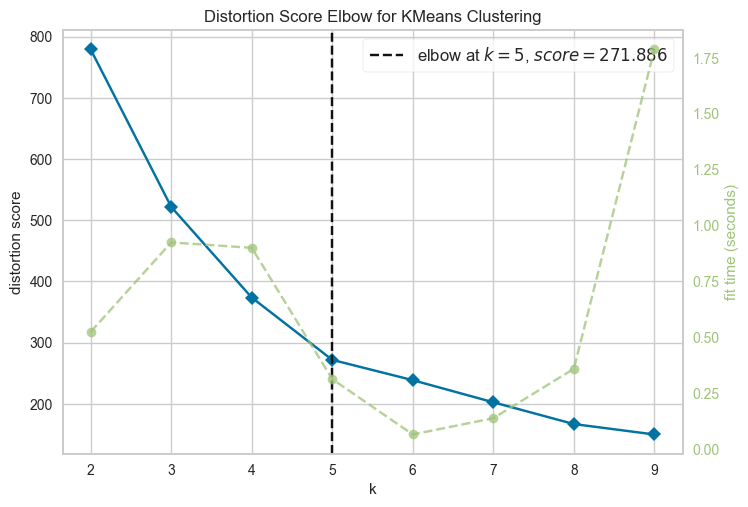

In [13]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(rfm_scaled)
visualizer.show()
plt.show()

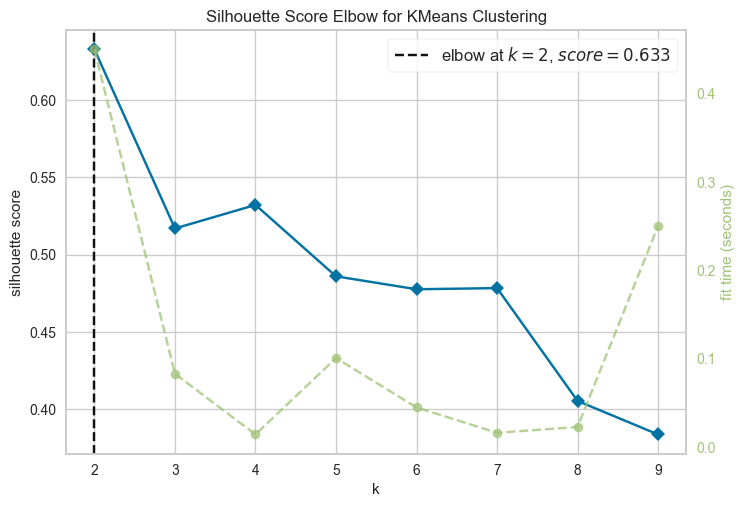

In [15]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(rfm_scaled)
visualizer.show()
plt.show()

In [41]:
# Initialize and fit the K-Means model
KM_5_clusters = KMeans(n_clusters=4, init='k-means++').fit(rfm_scaled)
# Convert rfm_scaled to a DataFrame if it's currently a NumPy array
KM5_clustered = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary']) # assuming these are the columns
# Append the cluster labels to the DataFrame
KM5_clustered['Cluster'] = KM_5_clusters.labels_


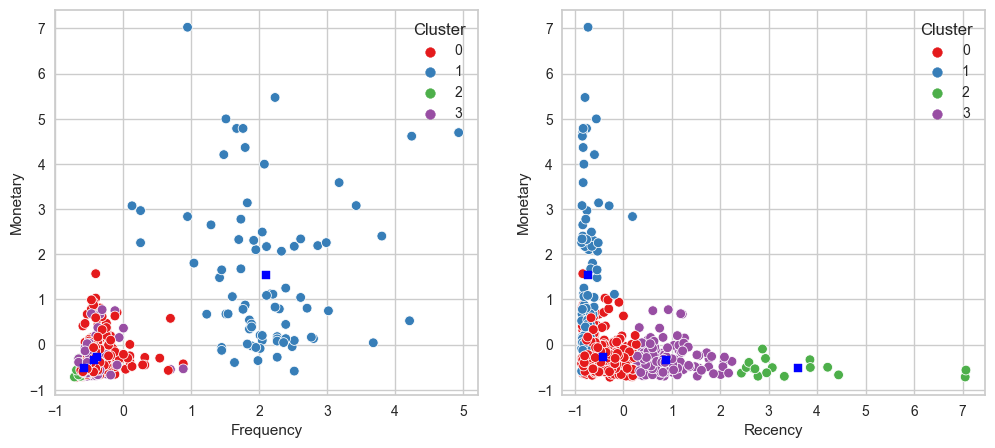

In [42]:
fig1, (axes) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot for 'Frequency' vs 'Monetary'
scat_1 = sns.scatterplot(x='Frequency', y='Monetary', data=KM5_clustered,
                         hue='Cluster', ax=axes[0], palette='Set1', legend='full')

# Scatter plot for 'Recency' vs 'Monetary'
sns.scatterplot(x='Recency', y='Monetary', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# Plotting the cluster centers
axes[0].scatter(KM_5_clusters.cluster_centers_[:, 1], KM_5_clusters.cluster_centers_[:, 2], 
                marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:, 0], KM_5_clusters.cluster_centers_[:, 2], 
                marker='s', s=40, c="blue")

plt.show()

In [43]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,273
1,80
2,17
3,123


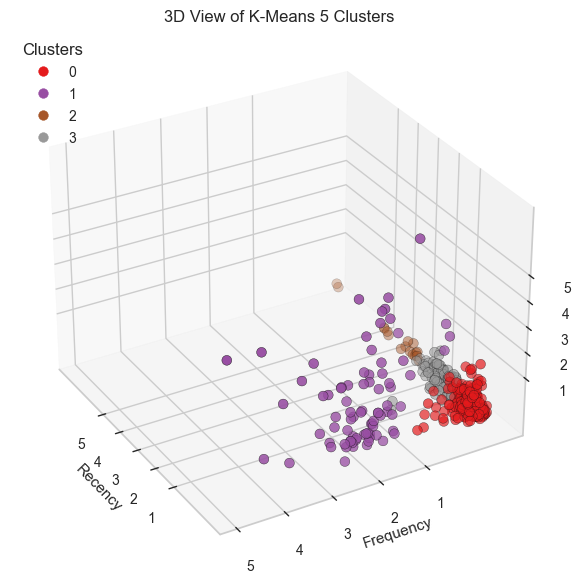

In [58]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the scatter plot
scatter = ax.scatter(KM5_clustered['Recency'],
                     KM5_clustered['Frequency'],
                     KM5_clustered['Monetary'],
                     c=KM5_clustered['Cluster'],
                     s=50, edgecolor='k', cmap=plt.cm.Set1)

# Menambahkan grid untuk referensi lebih baik
ax.grid(True)

# Menampilkan tick labels pada sumbu untuk referensi nilai
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_zticks([1, 2, 3, 4, 5])

# Setting axis labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D View of K-Means 5 Clusters')

# Menambahkan legenda
legend = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper left")

# Mengatur sudut pandang (elevasi dan sudut rotasi)
ax.view_init(elev=30, azim=150)

# Set distance of the view
ax.dist = 12

plt.show()


In [46]:
#Evaluasi dengan Silhoutte Socre
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Clustering dengan KMeans dan jumlah cluster 5
KM_5_clusters = KMeans(n_clusters=4, init='k-means++', random_state=1).fit(rfm_scaled)

# Mendapatkan label hasil clustering
labels = KM_5_clusters.labels_

# Menghitung Silhouette Score
silhouette_avg = silhouette_score(rfm_scaled, labels)

# Menampilkan Silhouette Score
print(f'Silhouette Score untuk 2 cluster: {silhouette_avg}')

Silhouette Score untuk 2 cluster: 0.5321720642597576


In [66]:
# Asumsikan cluster_labels berisi hasil clustering
KM5_results = pd.DataFrame({
    'KODE BARANG': rfm['KODE BARANG'],  # Pastikan ini sesuai
    'Cluster': KM_5_clusters.labels_
})

# Gabungkan DataFrame rfm dengan hasil clustering
KM5_clustered = rfm.merge(KM5_results, on='KODE BARANG')

# Menampilkan jumlah anggota di setiap cluster
cluster_counts = KM5_clustered.groupby('Cluster').size()
print("Jumlah anggota di setiap cluster:")
print(cluster_counts)

# Menampilkan anggota dari setiap cluster
for cluster_id in KM5_clustered['Cluster'].unique():
    print(f"\nProduk di Cluster {cluster_id}:")
    cluster_data = KM5_clustered[KM5_clustered['Cluster'] == cluster_id]
    
    # Menampilkan data dengan format yang lebih rapi
    print(cluster_data[['KODE BARANG', 'Recency', 'Frequency', 'Monetary']].to_string(index=False))


Jumlah anggota di setiap cluster:
Cluster
0     89
1     19
2    324
3     61
dtype: int64

Produk di Cluster 2:
KODE BARANG  Recency  Frequency  Monetary
        AA1      178          5  560000.0
       AA10      135          8 2880000.0
        AA2       83          6 3040000.0
        AA4      107          5  590000.0
        AA5       35          6  700000.0
        AA6       41         10 2400000.0
        AA7      173          9 2600000.0
        AA8       12         12 4950000.0
        AA9       81          8  900000.0
       AAP1       12         13 3050000.0
      AAP10       96          9  700000.0
      AAP11       71          6  375000.0
      AAP13       71          7 2250000.0
      AAP14        5          6  900000.0
      AAP15      162         18 2460000.0
       AAP2       63         10 1100000.0
       AAP3       32         17 2750000.0
       AAP4       22         34 1770000.0
       AAP5       37          8  480000.0
       AAP6      130          5  300000.0
     